# 特徵萃取其一

    在資料集上執行捲積基底(convolution base)，將輸出記錄到Numpy陣列，後輸入到獨立的密集層分類器

In [1]:
import tensorflow as tf 
from tensorflow import keras

tf.__version__

'2.1.0'

In [2]:
from tensorflow.keras.applications import VGG16

conv_base=VGG16(weights='imagenet',
               include_top=False, #不包含密集連接分類器
               input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = r'D:\Final\code\LAB\keras\dogs-vs-cats\cats_and_dogs_small' 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count,4,4,512)) #model最後的shape_size
    labels=np.zeros(sample_count)
    generator=datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #捲積基底層進行預測
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i, end=' ') # 由於萃取需要較長的時間，我們印出 i 來檢視進度
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
model=keras.Sequential([
    keras.layers.Dense(256,activation='relu',input_dim=4*4*512),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, 
                    train_labels,epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 632us/sample - loss: 0.5822 - acc: 0.6915 - val_loss: 0.4364 - val_acc: 0.8480
Epoch 2/30
2000/2000 [==============================] - 1s 401us/sample - loss: 0.4244 - acc: 0.8150 - val_loss: 0.3597 - val_acc: 0.8720
Epoch 3/30
2000/2000 [==============================] - 1s 397us/sample - loss: 0.3579 - acc: 0.8515 - val_loss: 0.3210 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 1s 402us/sample - loss: 0.3169 - acc: 0.8735 - val_loss: 0.2957 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 407us/sample - loss: 0.2950 - acc: 0.8775 - val_loss: 0.2875 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 399us/sample - loss: 0.2719 - acc: 0.8910 - val_loss: 0.2713 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 1s 392us/sample - loss: 0.2479 - acc: 0.9000 - val_loss: 0.2629 - va

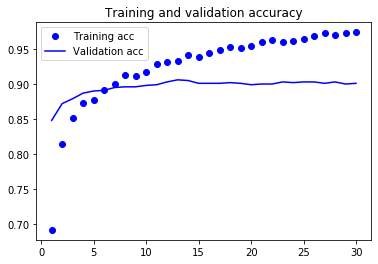

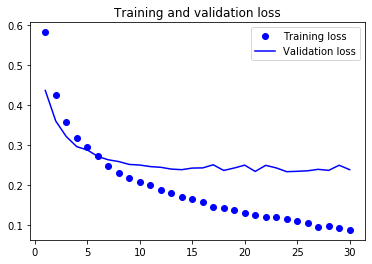

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 因為不能使用資料擴增法所以一開始就overfitting